Accuracy: 0.9715394566623544
Classification Report:
               precision    recall  f1-score   support

          MI       0.98      0.97      0.97       389
      Normal       0.97      0.98      0.97       384

    accuracy                           0.97       773
   macro avg       0.97      0.97      0.97       773
weighted avg       0.97      0.97      0.97       773



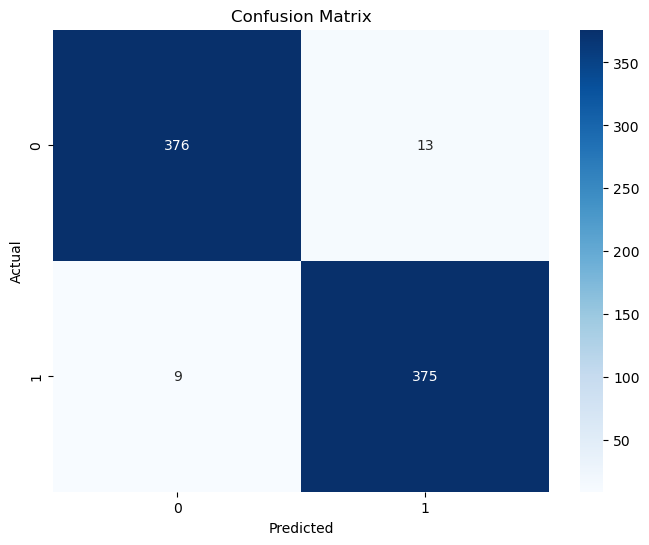

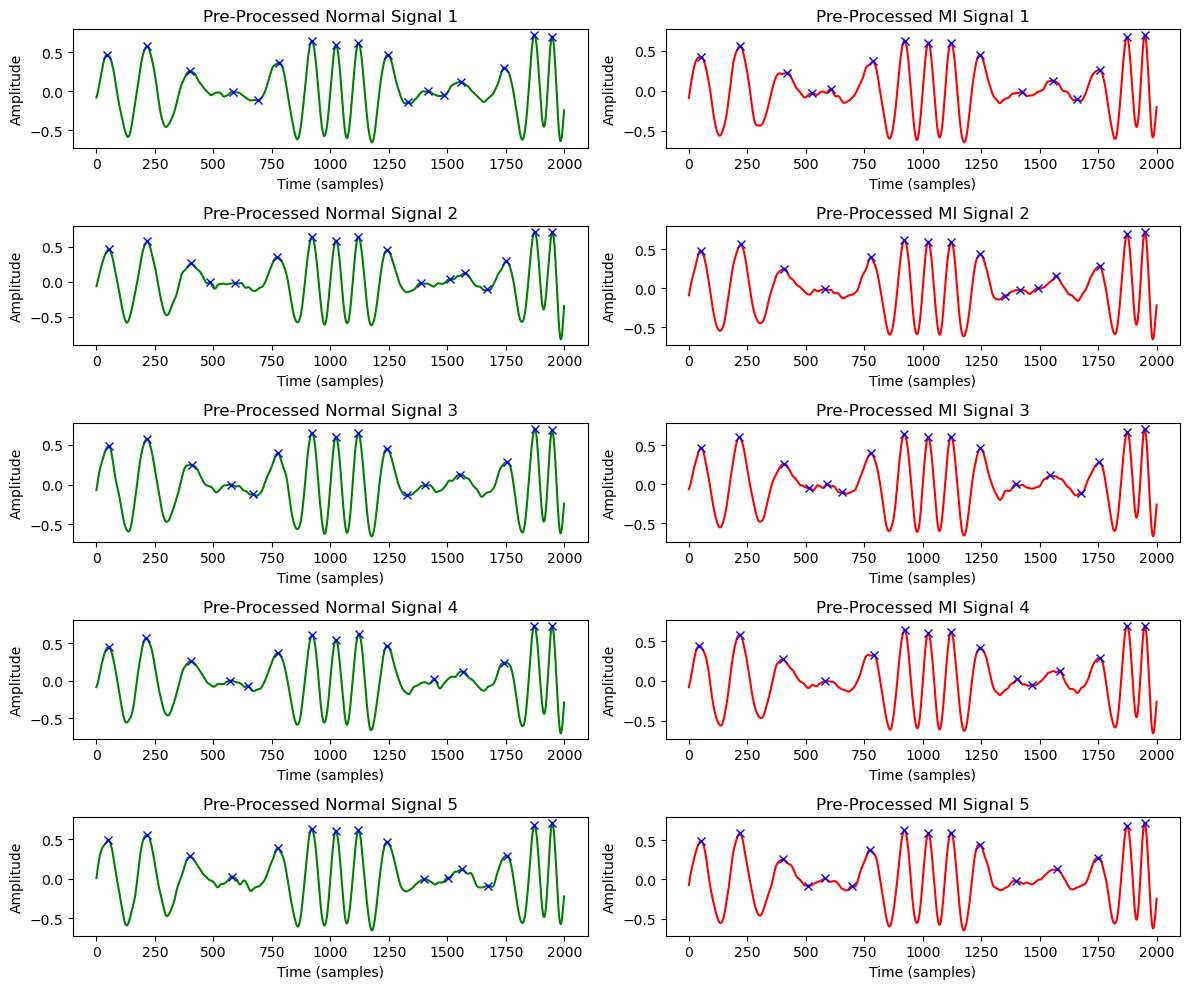

In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import skew
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Preprocessing: Bandpass Filter
def bandpass_filter(signal, fs, lowcut=0.5, highcut=3.5, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Feature Extraction
def extract_features(ppg_signal, fs):
    features = {}
    # Time-Domain Features
    features['mean'] = np.mean(ppg_signal)
    features['variance'] = np.var(ppg_signal)
    features['std_dev'] = np.std(ppg_signal)
    features['skewness'] = skew(ppg_signal)
    features['rms'] = np.sqrt(np.mean(ppg_signal**2))
    
    # Morphological Features
    peaks, _ = find_peaks(ppg_signal, distance=fs // 2)
    features['num_peaks'] = len(peaks)
    
    return features

# Load and preprocess data
def load_data(file_path):
    data = pd.read_csv(file_path)
    labels = data.iloc[:, -1].values  # Last column as labels
    ppg_signals = data.iloc[:, :-1].values  # All columns except the last as PPG signals
    fs = 125  # Sampling frequency
    return ppg_signals, labels, fs

# Visualize pre-processed signals with peaks
def plot_signals_with_peaks(signals, fs, labels, num_signals=5):
    normal_signals = signals[labels == 'Normal'][:num_signals]
    mi_signals = signals[labels == 'MI'][:num_signals]

    fig, axes = plt.subplots(num_signals, 2, figsize=(12, num_signals * 2))
    for i in range(num_signals):
        # Plot Normal Signals
        filtered_normal = bandpass_filter(normal_signals[i], fs)
        peaks, _ = find_peaks(filtered_normal, distance=fs // 2)
        axes[i, 0].plot(filtered_normal, color='green')
        axes[i, 0].plot(peaks, filtered_normal[peaks], "bx")
        axes[i, 0].set_title(f"Pre-Processed Normal Signal {i+1}")
        axes[i, 0].set_xlabel("Time (samples)")
        axes[i, 0].set_ylabel("Amplitude")

        # Plot MI Signals
        filtered_mi = bandpass_filter(mi_signals[i], fs)
        peaks, _ = find_peaks(filtered_mi, distance=fs // 2)
        axes[i, 1].plot(filtered_mi, color='red')
        axes[i, 1].plot(peaks, filtered_mi[peaks], "bx")
        axes[i, 1].set_title(f"Pre-Processed MI Signal {i+1}")
        axes[i, 1].set_xlabel("Time (samples)")
        axes[i, 1].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def main():
    # File path to your PPG dataset
    file_path = r"C:\Users\Arjun\PPG_Dataset.csv"
    ppg_signals, labels, fs = load_data(file_path)

    # Preprocess and extract features
    feature_list = []
    for signal in ppg_signals:
        filtered_signal = bandpass_filter(signal, fs)
        features = extract_features(filtered_signal, fs)
        feature_list.append(features)

    features_df = pd.DataFrame(feature_list)

    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)

    # Dimensionality Reduction using PCA
    num_features = min(features_df.shape[1], scaled_features.shape[0])
    pca = PCA(n_components=num_features)
    reduced_features = pca.fit_transform(scaled_features)

    # Train a Random Forest Classifier
    X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred)

    # Plot a sample of pre-processed signals with detected peaks
    plot_signals_with_peaks(ppg_signals, fs, labels)

main()
